# 顔画像を近似する最適化問題のPythonによる実装

目的関数
$
f(\boldsymbol{x}) = \| A \boldsymbol{x} - \boldsymbol{b} \|^2
$
を最小化するPythonの実装を行う．

ただし，$A$の各列を画像にする．
つまり，画像データセット中の複数の学習画像$A$を用いて，
対象となるテスト画像$\boldsymbol{b}$を近似する問題を扱う．
求めるベクトル$\boldsymbol{x}$は，各学習画像に対する係数となる．

この問題をADMMで解く際に反復により徐々に解へ近づく様子を視覚的に理解することがこの演習問題の目的である．


# 顔画像データセットの準備

In [1]:
# load modules

import numpy as np

import skimage.data

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
plt.gray();

import sklearn
from sklearn.datasets import fetch_olivetti_faces


<Figure size 432x288 with 0 Axes>

In [2]:
# check versions

print("sklearn version :", sklearn.__version__, " >= 0.18.0")
print("skimage version :", skimage.__version__, " >= 0.12.0")
print("numpy version :", np.__version__, " >= 0.12.0")
print("matplotlib version:", matplotlib.__version__, ">= 2.0.0")

sklearn version : 0.22.1  >= 0.18.0
skimage version : 0.16.2  >= 0.12.0
numpy version : 1.18.1  >= 0.12.0
matplotlib version: 3.1.3 >= 2.0.0


## 顔画像データセットのダウンロード

ここではsklearnのデータセットとして準備されているOlivetti facesデータセットを用いる．
詳しくは[sklearnのマニュアル](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html)を参照．

このデータセットには400枚の顔画像があり，それぞれが4096次元のベクトルである（64x64画像を表す）．

In [3]:
# load the face dataset

dataset = fetch_olivetti_faces(shuffle=False)
faces = dataset.data

In [4]:
# faces has images as its row vectors

nsamples, dim = faces.shape
print("there are", nsamples, "samples of dimension", dim)

there are 400 samples of dimension 4096


In [5]:
# see the inside of faces

faces

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

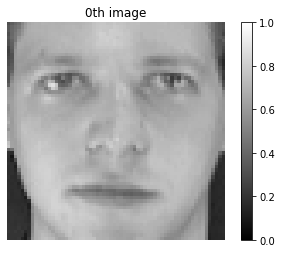

In [6]:
# show 0-th image with colorbar (pixel values range from 0 to 1)

# reshape(64,64) converts a vector into a 64x64 image 
imshow(faces[0].reshape(64,64), vmin=0, vmax=1) # set vmin=0 and vmax=1 to display value 0 to be black, and 1 white (otherwise min value is black and max value is white)

plt.colorbar() # show colorbar
plt.axis('off') # turn off border ticks
plt.title("0th image"); # set title

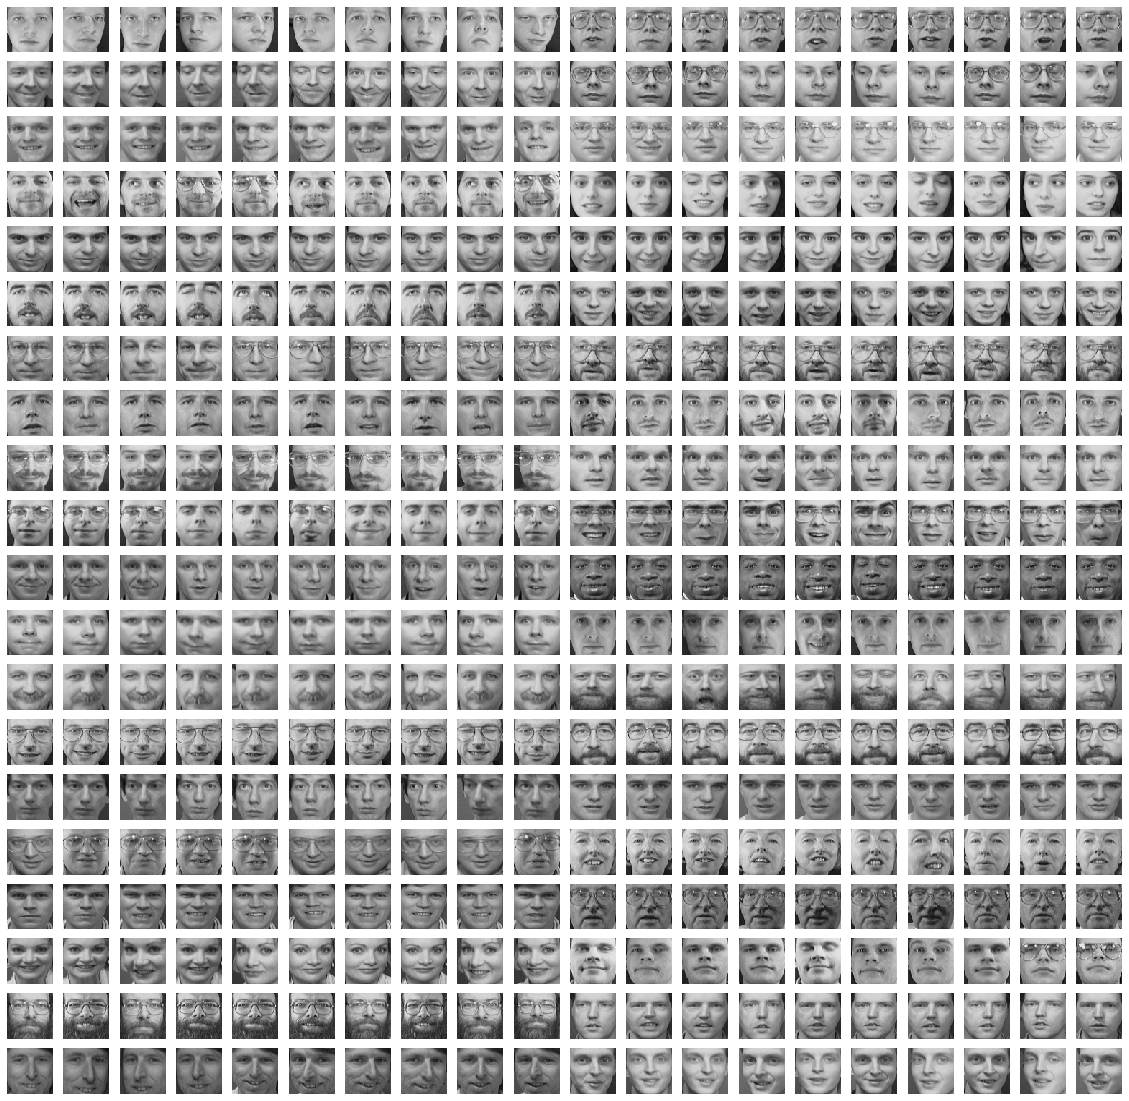

In [7]:
# show all 400 images. takes time, wait for a while....

plt.figure(figsize=(20, 20))
for i, p in enumerate(faces):
    plt.subplot(20, 20, i + 1)
    
    plt.imshow(faces[i].reshape(64,64), vmin=0, vmax=1)
    
    plt.axis('off')

# 行列$A$の定義


データセットの各学習画像をベクトル$\boldsymbol{x}_i$とみなす．
各画像は2次元配列だが，1次元配列にreshapeする（Olivetti facesデータセットの場合にはすでに各画像が1次元配列になっている）．
学習画像として最初の200枚を用いることにする．


In [8]:
A = faces[:200].transpose()

`A`の各列は4096次元のベクトルである．

In [9]:
A.shape

(4096, 200)

テスト画像であるベクトル$\boldsymbol{b}$としては201〜400枚目のどれかを用いる．

In [10]:
b = faces[201] # 例えば201枚目

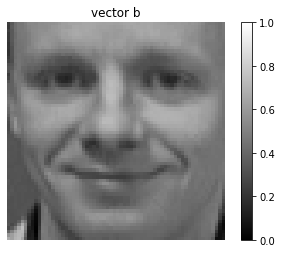

In [11]:
imshow(b.reshape(64,64), vmin=0, vmax=1)

plt.colorbar()
plt.axis('off')
plt.title("vector b");

# 最適化問題を解く

この最小化問題をADMMで解く．そのためにソフトしきい値関数を定義する．

In [12]:
def soft_th(x, lmd):
    return np.sign(x) * np.maximum(np.abs(x) - lmd, 0.)

それではこれを固定回数だけ反復する．
反復がわかりやすいようにプログレスバーをつけて，rmseが表示されるようにする．

In [13]:
from tqdm import tqdm

In [14]:
fval = []
gval = []
xval = []
totalval = []
faces = []

nfaces = A.shape[1]
x0 = np.random.randn(nfaces)
x0 /= np.linalg.norm(x0)

I_n = np.eye(A.shape[1])

lmd = 5
rho = 50
alpha = 1e-1
niter = 500

zk = lk = xk = x0
with tqdm(range(niter)) as prog_bar:
    for k in prog_bar:

        xk1, _, _, _ = np.linalg.lstsq(A.T @ A + rho * I_n, 
                                       A.T @ b + rho * zk - lk, 
                                       rcond=None)
        zk1 = soft_th(xk1 + lk / rho, lmd / rho)
        lk1 = lk + alpha * rho * (xk1 - zk1)

        xk = xk1
        zk = zk1
        lk = lk1
        
        rmse = np.linalg.norm(A @ xk - b)
        fval.append(rmse)
        gval.append(np.linalg.norm(xk - zk))
        xval.append(np.linalg.norm(xk, ord=1))
        totalval.append(np.linalg.norm(A @ xk - b) / 2 + lmd * np.linalg.norm(xk, ord=1))
        faces.append(A @ xk)
        prog_bar.set_postfix(rmse=rmse)


100%|██████████| 500/500 [00:10<00:00, 46.28it/s, rmse=3.68]


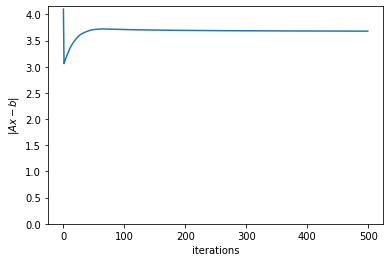

In [15]:
plt.plot(fval)
plt.xlabel('iterations')
plt.ylabel('$\| Ax - b \|$')
plt.ylim(ymin=0)
plt.show();

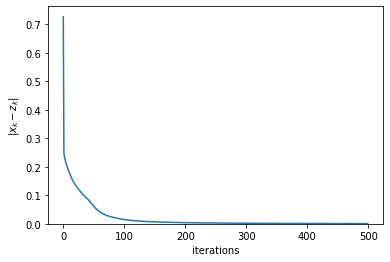

In [16]:
plt.plot(gval)
plt.xlabel('iterations')
plt.ylabel('$\| x_k - z_k \|$')
plt.ylim(ymin=0)
plt.show();

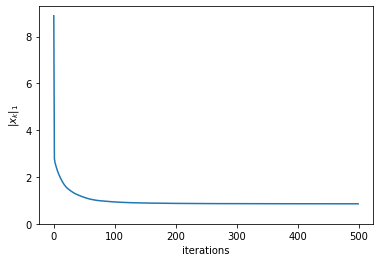

In [17]:
plt.plot(xval)
plt.xlabel('iterations')
plt.ylabel('$\| x_k \|_1$')
plt.ylim(ymin=0)
plt.show();

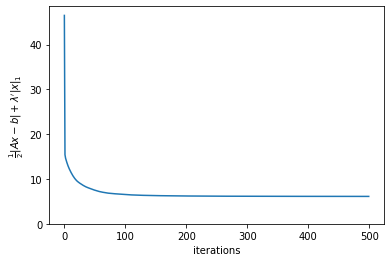

In [18]:
plt.plot(totalval)
plt.xlabel('iterations')
plt.ylabel('$\\frac{1}{2} \| Ax - b \| + \lambda\' \| x \|_1 $')
plt.ylim(ymin=0)
plt.show();

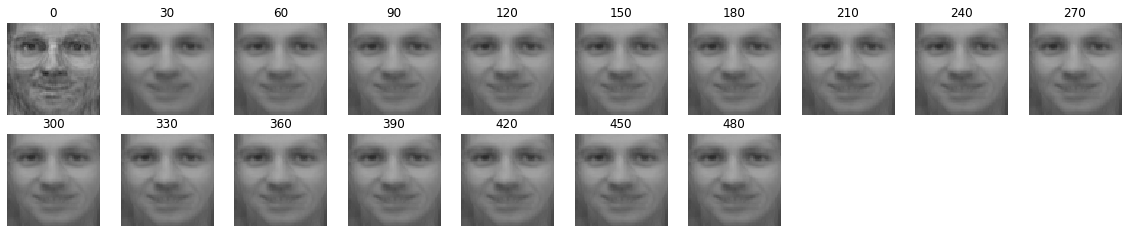

In [19]:
plt.figure(figsize=(20, 20))

for i, v in enumerate(range(0, 500, 30)):

    plt.subplot(10, 10, i + 1)

    imshow(faces[v].reshape(64, 64), vmin=0, vmax=1)
    plt.title(v)

    plt.axis('off')

plt.show();

# Task


- $\lambda, \rho$の値を変えて，収束の様子を同時にプロットして比較せよ．
- 以下の場合について，結果を議論せよ．
 - テスト画像$b$に，学習に用いた画像（つまり$A$のどれかの列）を用いた場合
 - テスト画像$b$に，学習に用いた2枚の画像の平均（つまり$A$のどれか2列の平均）を用いた場合